In [19]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import numpy.linalg as la
from scipy.special import logsumexp

# K-Means Algorithm for Clustering


The $k$-means clustering algorithm maintains a list of $k$ cluster centers. In each iteration, it first assigns each training point to the cluster whose center is closest, and then moves each center to the mean of the points in the cluster. Thus, the algorithm can be written as follows. 
1. Initialize cluster centers $\mu_1, \mu_2, \ldots, \mu_k \in \mathbb{R}^d$ randomly to $k$ points in the training set.
2. Repeat until convergence:

For every $i$, set
$$
c^{(i)} \leftarrow \arg \min _j\left\|x^{(i)}-\mu_j\right\|^2 .
$$
For each $j$, set
$$
\mu_j\leftarrow\frac{\sum_{i=1}^n 1[c^{(i)}=j] x^{(i)}}{\sum_{i=1}^n 1[c^{(i)}=j]} .
$$

## Initialize centroids

In [5]:
def kmeans_init(data, K):
    """
    Parameters:
        data: the dataset
        K: the number of centroids
    Return:
        K_centroids: (K, d)
    """
    idx = np.random.choice(len(data), K, replace=False)
    K_centroids = data[idx, :]

    N, d = data.shape
    # assert K_centroids.shape == (K, d)
    return K_centroids

## Assign Data to Centroids

The first step in the $k$-means loop is to re-assign each data point to the cluster whose center is closest according to some distance metric. We will use the L2 norm. 

In [6]:
def L2_norm(x, c):
    """
    Parameters:
        x: a data point
        c: a centroid
    Return:
        The Euclidean distance between x and c
    """
    return np.sqrt(np.sum((x - c) ** 2))

In [7]:
def assign_to_centroids(data, K_centroids):
    """
    Parameters:
        data: the dataset (N, d)
        K_centroids: (K, d)
    Return
        assignment: (N,), the assignment of each data point based on different centroids
    """

    N, d = data.shape
    K = K_centroids.shape[0]
    labels = np.empty(N, dtype=np.int8)

    for i, xi in enumerate(data):

        minimum = 1e10
        centroid_idx = 0

        for j, centroid in enumerate(K_centroids):

            d = la.norm(xi - centroid)

            if d < minimum:

                minimum = d
                centroid_idx = j

        labels[i] = centroid_idx

    return labels

In [8]:
# Sample Test Case

np.random.seed(0)
sample_data = np.arange(35).reshape(5, 7) % 20
sample_K_centroids = sample_data[[1, 3, 4], :]
sample_assignment = assign_to_centroids(sample_data, sample_K_centroids)
assert np.array_equal(sample_assignment, np.array([1, 0, 2, 1, 2]))

## Update centroids

Re-compute the cluster centers by taking the mean of the data points belonging to each cluster.

In [10]:
def update_centroids(data, K, labels):
    """
    Parameters:
        data: (N, d)
        K: scalar
        assignment: (N,)
    """

    K_centroids = np.zeros((K, data.shape[1]))
    centroid_counts = np.zeros(K)

    for idx, pair in enumerate(zip(data, labels)):

        xi, label = pair

        K_centroids[label] += xi

        centroid_counts[label] += 1

    for idx, count in enumerate(centroid_counts):

        K_centroids[idx] /= count

    # assert len(K_centroids) == K
    return K_centroids

In [11]:
# Sample Test Case

np.random.seed(0)
sample_data = np.arange(35).reshape(5, 7) % 20
sample_K = 3
sample_assignment = np.array([1, 0, 2, 1, 2])
sample_updated_K_centroids = update_centroids(sample_data, sample_K, sample_assignment)
assert np.array_equal(
    sample_updated_K_centroids.round(2),
    np.array(
        [
            [7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0],
            [0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5],
            [11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 7.0],
        ]
    ).round(2),
)

## Assemble

Combine the above functions together to build the K-means clustering algorithm until convergence and measure the sum of squares error.

In [13]:
def SSE(C, D, A):
    """
    params:
        C: K Centroids, K x d
        D: Dataset, N x d
        A: Assignment of data points, N x 1
    returns:
        Sum-of-Square-Error
    """
    D_C = []
    for a in A:
        D_C.append(C[int(a)])
    D_C = np.array(D_C)
    return np.sum((D_C - D) ** 2)


def KMeans(data, K):
    np.random.seed(0)
    # Initialize centroids
    K_centroids = kmeans_init(data, K)
    while True:
        assignment = assign_to_centroids(data, K_centroids)
        prev_K_centroids = K_centroids.copy()
        K_centroids = update_centroids(data, K, assignment)
        if np.array_equal(prev_K_centroids, K_centroids):  # Until convergence
            break

    return SSE(K_centroids, data, assignment)

## Experiments

### 1979 European [Employment data](http://www.dm.unibo.it/~simoncin/EuropeanJobs.html)

This dataset gives the percentage of people employed in each of a set of areas in 1979 for each of a set of European countries. Only contains 26 data points.

In [15]:
df = pd.read_csv("EuropeanJobs.dat", sep="\t", header=0)
df.head()

Country   Agr  Min   Man   PS  Con    SI  Fin   SPS   TC
0     Belgium   3.3  0.9  27.6  0.9  8.2  19.1  6.2  26.6  7.2
1     Denmark   9.2  0.1  21.8  0.6  8.3  14.6  6.5  32.2  7.1
2      France  10.8  0.8  27.5  0.9  8.9  16.8  6.0  22.6  5.7
3  W. Germany   6.7  1.3  35.8  0.9  7.3  14.4  5.0  22.3  6.1
4     Ireland  23.2  1.0  20.7  1.3  7.5  16.8  2.8  20.8  6.1

Variable Names:
1. Country: Name of country
2. Agr: Percentage employed in agriculture
3. Min: Percentage employed in mining
4. Man: Percentage employed in manufacturing
5. PS: Percentage employed in power supply industries
6. Con: Percentage employed in construction
7. SI: Percentage employed in service industries
8. Fin: Percentage employed in finance
9. SPS: Percentage employed in social and personal services
10. TC: Percentage employed in transport and communications

In [16]:
feature_cols = ["Agr", "Min", "Man", "PS", "Con", "SI", "Fin", "SPS", "TC"]
X = df[feature_cols].values
Y = df["Country"].tolist()

### Experimenting with different values of $k$

In [17]:
k_list = range(2, 25)
k_sse = []
for k in range(2, 25):
    k_sse.append(KMeans(X, k))

Now, we plot the within-cluster sum of square error based on different $K$'s.

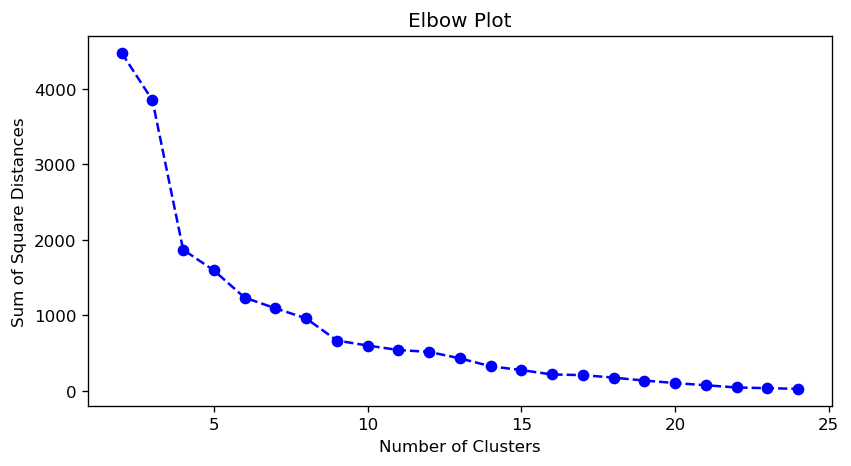

In [18]:
plt.figure(figsize=(8, 4), dpi=120)
plt.title("Elbow Plot")
plt.xlabel("Number of Clusters")
plt.ylabel("Sum of Square Distances")
_ = plt.plot(k_list, k_sse, "bo--")

The value of K located at the elbow is the best value for K, as there are rapidly diminishing returns after this value, which is approximately k = 4 in this case.

# Expectation-Maximization for Mixture of Gaussians

Recall that expectation-maximixation is an algorithm that identifies parameters of a distribution with latent variables to describe a training set. It computes a local optimum for the maximum likelihood estimation in such cases. 

Here, the distribution to be learnt is a mixture of Gaussians. The distribution for the training set is constructed by picking $z \in \{1,2,\ldots k\}$ using the multinomial distribution, and then picking point $x$ from the $z^{\text{th}}$ multinomial normal distribution. We assume each of the multinomial distributions is a product of $d$ independent uni-variate normal distributions such taht the covariance matrix $\Sigma$ of these distributions is the identity matrix.

**EM update formulas for the Gaussian mixture model:** 

The parameters are as follows: $\phi_1, \phi_2, \ldots \phi_k$ of the multinomial distribution, where $\phi_i$ is the probability of picking the $i^{\text{th}}$ distribution; and $\mu_1, \mu_2, \ldots \mu_k$, where $\mu_i \in \mathbb{R}^d$ is the mean of the $i^{\text{th}}$ Gaussian. We don't have parameters for the covariance matrices because as discussed in the previous paragraph, we are assuming that these are the identity matrix. The EM algorithm also tracks $W_{i,j}$ which is the probability that the $i^{\text{th}}$ training example $x^{(i)}$ was drawn from the $j^{\text{th}}$ distribution. The EM algorithm updates these values iteratively using the E-step and M-step. We denote the value of a parameter in the $m^{\text{th}}$ iteration by adding a superscript $(m)$; thus, $\phi_i^{(m)}$ denotes the value of $\phi_i$ in the $m^{\text{th}}$ iteration, and $W_{i,j}^{(m)}$ denotes the value of $W_{i,j}$ in the $m^{\text{th}}$ iteration. Using this notation, the update rules can be written as follows.
1. The E-step
$$
W_{i, j}^{(m)}=\frac{\left[e^{-\frac{1}{2}\left[\left(\mathbf{x}_i-\boldsymbol{\mu}_j\right)^\intercal\left(\mathbf{x}_i-\boldsymbol{\mu}_j\right)\right]}\right] \phi_j^{(m)}}{\sum_{l=1}^k\left[\left[e^{-\frac{1}{2}\left[\left(\mathbf{x}_i-\boldsymbol{\mu}_l\right)^\intercal\left(\mathbf{x}_i-\boldsymbol{\mu}_l\right)\right]}\right] \phi_l^{(m)}\right]}.
$$ 
2. The M-step
$$
\begin{aligned}
\phi_j^{(m+1)} &=\frac{\sum_{i=1}^N W_{i, j}^{(m)}}{N}\\
\mu_j^{(m+1)} &=\frac{\sum_{i=1}^N x^{(i)} W_{i, j}^{(m)}}{\sum_{i=1}^N W_{i, j}^{(m)}}
\end{aligned}
$$
where $N$ is the size of the training set, $d$ is the number of features in the data point, and $x^{(i)} \in \mathbb{R}^d$ is the $i^{\text{th}}$ training example.

## Expectation Step

$$H_{i,j} := -\frac{1}{2} \bigg[ (\mathbf{x}_i-\mathbf{\mu}_j)^T(\mathbf{x}_i-\mathbf{\mu}_j) \bigg] = -\frac{1}{2} \bigg[ \mathbf{x}_i^T \mathbf{x}_i+ \mathbf{\mu}_j^T \mathbf{\mu}_j - 2\mathbf{x}_i^T\mathbf{\mu}_j\bigg]$$

The entries of the matrix $H$ correspond to exponent of the exponentials that appears in the expressions that need to be computed in the E-step.

$$\$$

We can simplifty the H calculation by manipulationg the expression:

$$H = -\frac{1}{2}(H_1+H_2-2H_3)$$
where
$$H_1 = \bigg[X \circ X \bigg]\cdot \mathbf{1}_{d\times K}$$
$$H_2 = \mathbf{1}_{N\times d} \cdot \bigg[\mu \circ \mu \bigg]^\intercal$$
$$H_3 = X \cdot \mu^T$$
and 
$\mathbf{1}_{1\times K}$ is a matrix of shape $1\times K$ with all ones, $\circ$ is element-wise matrix multiplication.

In [20]:
def find_H(X, mu):
    """
    Parameters:
        X: data (N, d)
        mu: the K mean values (K, d)
    Return:
        H: shape (N, k)
    """
    N, d = X.shape
    K = mu.shape[0]
    assert X.shape[1] == mu.shape[1]

    H1 = (X * X) @ np.ones((d, K))
    H2 = np.ones((N, d)) @ (mu * mu).T
    H3 = X @ mu.T
    H = -0.5 * (H1 + H2 - 2 * H3)
    # assert H.shape == (N,K)
    # assert H.dtype == np.float64
    return H

In [21]:
# Sample Test Case
some_X = np.array(
    [
        [0, 1, 12, 3, 4],
        [5, 16, 7, 8, 9],
        [0, 11, 12, 13, 4],
        [15, 16, 17, 8, 19],
        [0, 1, 12, 3, 4],
        [5, 16, 7, 8, 13],
        [4, 15, 0, 5, 0],
    ]
)

some_mu = np.array([[0, 1, 18, 15, 5], [13, 9, 23, 3, 22], [2, 10, 17, 4, 8]])

assert np.array_equal(
    find_H(some_X, some_mu).round(2),
    np.array(
        [
            [-90.5, -339.0, -63.5],
            [-218.0, -281.5, -81.0],
            [-70.5, -359.0, -63.5],
            [-348.0, -61.5, -171.0],
            [-90.5, -339.0, -63.5],
            [-242.0, -237.5, -93.0],
            [-330.5, -567.0, -191.5],
        ]
    ).round(2),
)

### Task 5: find_logW

In this subtask, we will write the code to compute the matrix $W$. However, it ensure numerical stability, it is better to compute the $\log$ of all its entries. 

The function `find_logW` calculates the $\log W_{i,j}$ for each $i,j$, and takes the following arguments as input:

1. `H`: A numpy array of the shape `(N,K)` where `N` and `K` are as defined in Task 4. This is the supposed output of the `find_H` function you wrote.
2. `log_phi`: A numpy array of the shape `(K,1)`.  

Your function should return the numpy array `logW` with the shape of `(N, K)` whose $i^{th}$ row and $j^{th}$ column should be

$$\log W_{i,j} := \log\bigg(\frac{\phi_j \exp\bigg(-\frac{1}{2} \bigg[ (\mathbf{x}_i-\mathbf{\mu}_j)^T(\mathbf{x}_i-\mathbf{\mu}_j) \bigg]\bigg)}{\sum_{l=1}^{K} \phi_l \exp\bigg(-\frac{1}{2} \bigg[ (\mathbf{x}_i-\mathbf{\mu}_l)^T(\mathbf{x}_i-\mathbf{\mu}_l) \bigg]\bigg)}\bigg)$$

**Important Note**: You **should** use the [`logsumexp`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.logsumexp.html) function imported above from scipy's library to ensure numerical stability. In other words, don't try and exponentiate the vector `log_phi` to obtain the $\phi$ vector; this will result in numerical instability. 

In [22]:
def find_logW(H, log_phi):
    """
    Parameters:
        H: the H matrix of shape (N, K)
        log_phi: an array of all the natural log of pi, shape (K, 1)
    Return:
        logW: (N, K) as indicated above
    """

    N, K = H.shape
    log_phi = log_phi.flatten()
    logW = np.zeros((N, K))

    for i in range(N):

        Hi = H[i][:]

        numerator = log_phi + Hi

        denominator = logsumexp(Hi + log_phi)

        logW[i][:] = numerator - denominator

    # assert logW.shape == (N,K)
    # assert not np.isnan(logW).any()
    # assert not np.isinf(logW).any()
    return logW

In [34]:
# Sample Test Case

some_mu = np.array([[0, 1, 18, 15, 5], [13, 9, 23, 3, 22], [2, 10, 17, 4, 8]])
some_H = np.array(
    [
        [-90.5, -339.0, -63.5],
        [-218.0, -281.5, -81.0],
        [-70.5, -359.0, -63.5],
        [-348.0, -61.5, -171.0],
        [-90.5, -339.0, -63.5],
        [-242.0, -237.5, -93.0],
        [-330.5, -567.0, -191.5],
    ]
)

some_log_phi = np.log(some_mu.sum(axis=1) / some_mu.sum()).reshape(-1, 1)

some_logW = find_logW(some_H, some_log_phi)

assert np.allclose(
    some_logW.round(2),
    np.array(
        [
            [-27.05, -274.97, -0.0],
            [-137.05, -199.97, 0.0],
            [-7.05, -294.97, -0.0],
            [-287.08, 0.0, -110.03],
            [-27.05, -274.97, -0.0],
            [-149.05, -143.97, 0.0],
            [-139.05, -374.97, 0.0],
        ]
    ),
)

## 2.2 The Maximization Step

In the M-step, the two subtasks we have are to update $\log \phi$ and $\mu$. 

### Task 6: update_logphi

Since the computation of $\log W$ uses $\log \phi$, in this next task we will comput $\log \phi$ instead of $\phi$ directly. Write a function `update_logphi` that computes the new $\log \phi$ vector, and takes the following argument as input:

1. `logW`: A numpy array of the shape `(N,K)` where `N` and `K` are as defined before. This is the supposed output of the `find_logW` function you wrote.

Your function should return the numpy array `log_phi` with the shape of `(K, 1)` whose $j^{th}$ element should be

$$\log \phi_{j} := \log \frac{\sum_{i=1}^N W_{i,j}}{N}$$

**Important Note**: You **should** use the `logsumexp` function imported above from scipy's library to make sure that numerical stability would not be a problem. In other words, don't try and exponentiate the matrix `logW` to obtain the $W$ matrix; this will result in numerical instability. 

**Important Note**: Please don't use loops for constructing this posterior. 

To be computationally more efficient, please do the following computation to calculate $\phi$:

$$\log(\phi) = \log W^T \cdot \mathbf{1}_{N×1} − \log(N)$$

In [23]:
def update_logphi(logW):
    N, K = logW.shape
    log_phi = logsumexp(logW, axis=0) - np.log(N)
    log_phi = np.reshape(log_phi, (K, 1))

    # assert log_phi.shape == (K,1)
    # assert not np.isnan(log_phi).any()
    # assert not np.isinf(log_phi).any()

    return log_phi

In [44]:
# Sample Test Case
some_logW = np.array(
    [
        [-27.05, -274.97, -0.0],
        [-137.05, -199.97, 0.0],
        [-7.05, -294.97, -0.0],
        [-287.08, 0.0, -110.03],
        [-27.05, -274.97, -0.0],
        [-149.05, -143.97, 0.0],
        [-139.05, -374.97, 0.0],
    ]
)

some_logphi_new = update_logphi(some_logW)
print(some_logphi_new)
assert np.array_equal(some_logphi_new.round(2), np.array([[-9.0], [-1.95], [-0.15]]))

[[-8.99591014]
 [-1.94591015]
 [-0.15415068]]


### Task 7: update_mu

Write a function `update_mu` that computes the new $\mu$ matrix that computes the updated means of each of $k$ Gaussian distributions. `update_mu` takes the following arguments as input:

1. `X`: A numpy array of the shape `(N,d)` where `N` and `d` are as defined before.  
  
2. `logW`: A numpy array of the shape `(N,K)`. This is the supposed output of the `find_logW` function you wrote

Your function should return the numpy array `mu` with the shape of `(K, d)` whose $j^{th}$ mean should be

$$\mathbf{\mu}_j = \frac{\sum_{i=1}^N \mathbf{x_i} W_{i,j}}{\sum_{i=1}^N W_{i,j}}$$

**Important Note**: Don't use loops for constructing this posterior. To be computationally more efficient, please do the following computation to calculate $\mu$:

$$\mu = (W^T \cdot X) \oslash (W^T \cdot \mathbf{1}_{N×d})$$

where $\oslash$ is the element-wise matrix division operation.

$$ R = W^T = \exp\big[\log(W^T)\big]$$
$$ \mu = (R \cdot X) \oslash (R \cdot \mathbf{1}_{N×d})$$

In [45]:
# grade


def update_mu(X, logW):
    N, K = logW.shape
    d = X.shape[1]
    assert X.shape[0] == N

    ### BEGIN CODE

    R = np.exp(logW).T
    mu = (R @ X) / (R @ np.ones((N, d)))

    ### END CODE

    # assert mu.shape == (K,d)
    # assert not np.isnan(mu).any()
    # assert not np.isinf(mu).any()

    return mu

In [46]:
# Sample Test Case
some_X = np.array(
    [
        [0, 1, 12, 3, 4],
        [5, 16, 7, 8, 9],
        [0, 11, 12, 13, 4],
        [15, 16, 17, 8, 19],
        [0, 1, 12, 3, 4],
        [5, 16, 7, 8, 13],
        [4, 15, 0, 5, 0],
    ]
)

some_logW = np.array(
    [
        [-27.05, -274.97, -0.0],
        [-137.05, -199.97, 0.0],
        [-7.05, -294.97, -0.0],
        [-287.08, 0.0, -110.03],
        [-27.05, -274.97, -0.0],
        [-149.05, -143.97, 0.0],
        [-139.05, -374.97, 0.0],
    ]
)

some_mu_new = update_mu(some_X, some_logW)

assert np.array_equal(
    some_mu_new.round(3),
    np.array(
        [
            [0.0, 11.0, 12.0, 13.0, 4.0],
            [15.0, 16.0, 17.0, 8.0, 19.0],
            [2.333, 10.0, 8.333, 6.667, 5.667],
        ]
    ),
)

## 2.3 Writing the full Expectation-Maximization Iteration

In [47]:
def GMM(X, K, iterations=100):
    N, d = X.shape
    pi_init = np.ones((K, 1)) / float(K)

    np.random.seed(0)
    mu_init = X[np.random.choice(N, K), :]  # mu.shape = (K, d)

    log_phi = np.log(pi_init)  # log_pi.shape = (K,1)
    mu = mu_init

    for iteration in range(iterations):
        print(".", end="")
        # The E-Step
        H = find_H(X, mu)
        logW = find_logW(H, log_phi)

        # The M-Step
        log_phi = update_logphi(logW)
        mu = update_mu(X, logW)
    print("", end=" ")

    return mu, H, log_phi

# 3. Image Segmentation

**Image segmentation using EM**: The results of an EM algorithm can be used to segment an image. The idea is as follows. Each pixel will be treated as a data point in a training set, and the RGB values at the pixel will be the features of a data point. We will use EM to train a mixture of Gaussians; the number of Gaussian distributions being a hyperparameter with a larger number resulting in a richer image. After running the EM algorithm on the image, the $W_{i,j}$ values estimate the probability with which pixel $i$ is drawn from distribution $j$. Like in softmax regression, we will "assign" pixel $i$ to the distribution $j$ for which $W_{i,j}$ is the largest. To segment the image, we will replace the RBG values of pixel $i$ by the mean of the distribution $j$. While that is the high level algorithm, in the implementation, instead of computing $W_{i,j}$, we will do the assignment of pixel to distribution using the $H$ matrix instead; you should be able to see that these will give equivalent results.

We have 3 images and in this task you will see the result of segmenting these images. (You could try running this on any image you like!) There is no code to be written in these tasks. We want you to 

* Segment each of the test images to 10, 20, and 50 segments (i.e., distributions in the mixture model). Display these images after segmentation. 


In [48]:
from skimage import io
import PIL.Image

In [49]:
def segment(raw_image, K):
    mu, H, log_phi = GMM(X=raw_image.reshape(-1, 3), K=K, iterations=10)
    reconst_image = mu[H.argmax(axis=1), :].reshape(*raw_image.shape)

    fig, axes = plt.subplots(1, 2, figsize=(8, 4), dpi=144)

    ax = axes[0]
    ax.imshow(raw_image)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title("Original Image")

    ax = axes[1]
    ax.imshow(reconst_image.astype(np.uint8))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"Segmented Image (K={K})")

    fig.tight_layout()
    plt.show()

## 3.1 The Sunset Image

.......... 

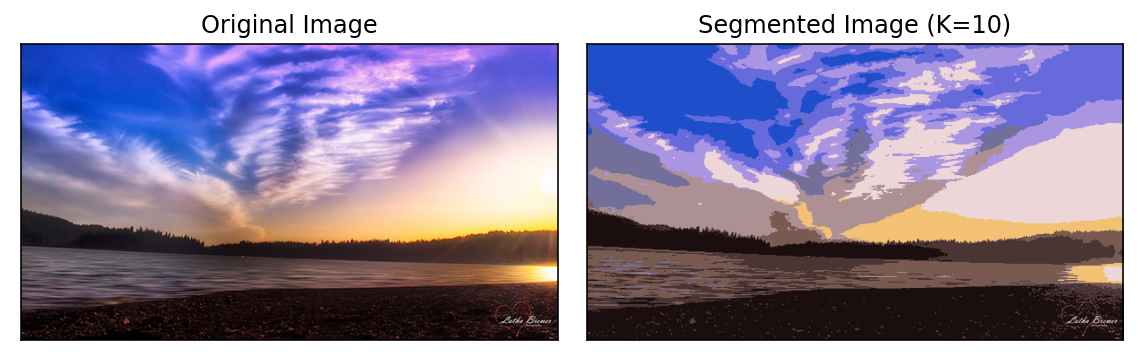

.......... 

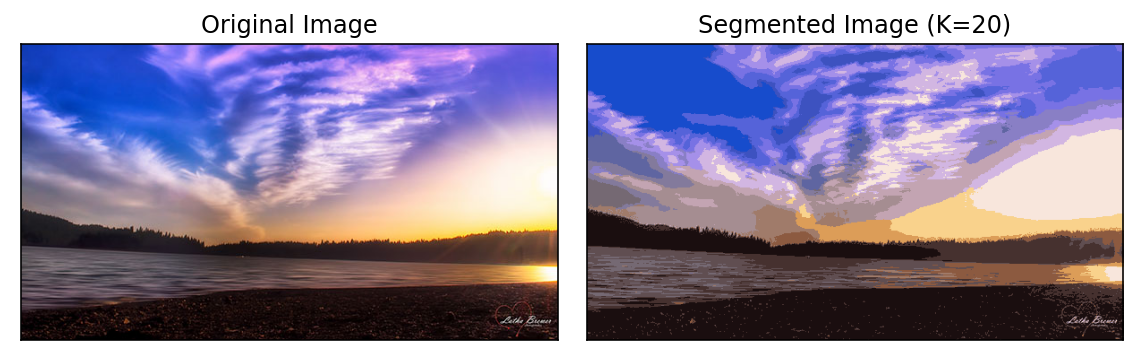

.......... 

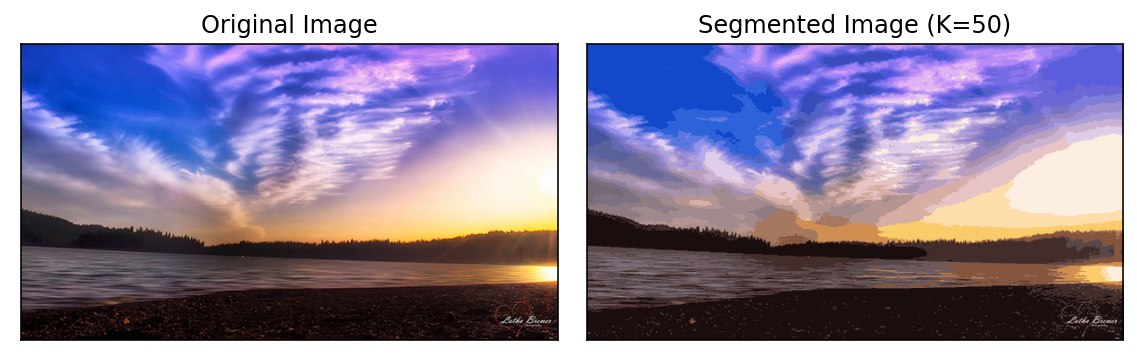

In [50]:
raw_image = io.imread("smallsunset.jpg")
segment(raw_image, 10)
segment(raw_image, 20)
segment(raw_image, 50)

## 3.2 The Flower Image

.......... 

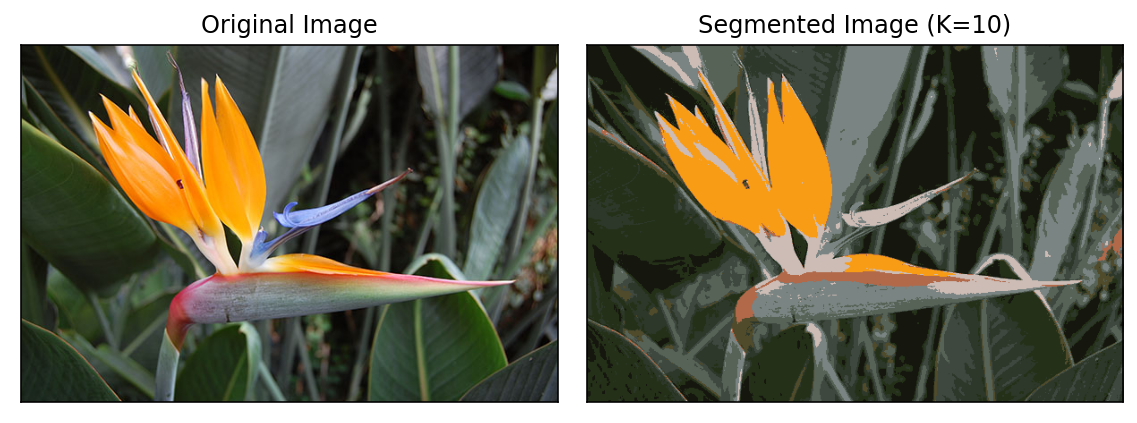

.......... 

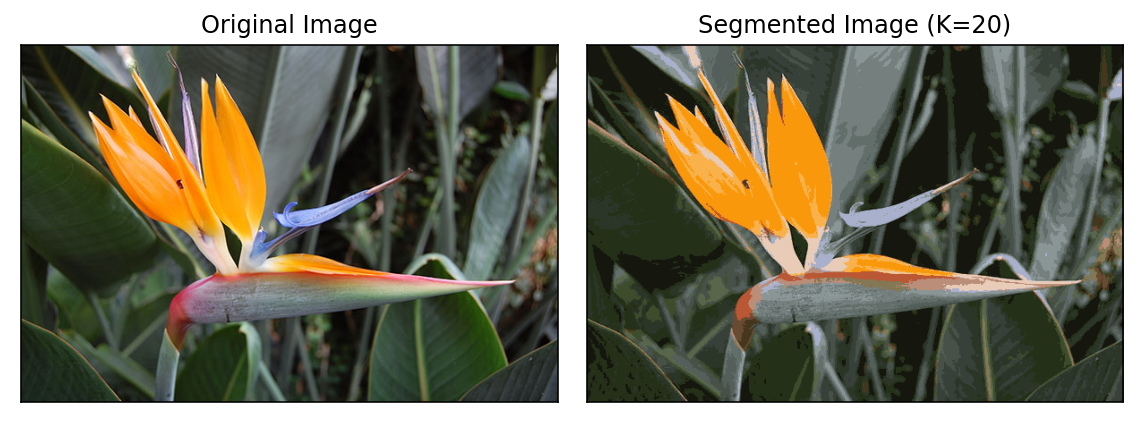

.......... 

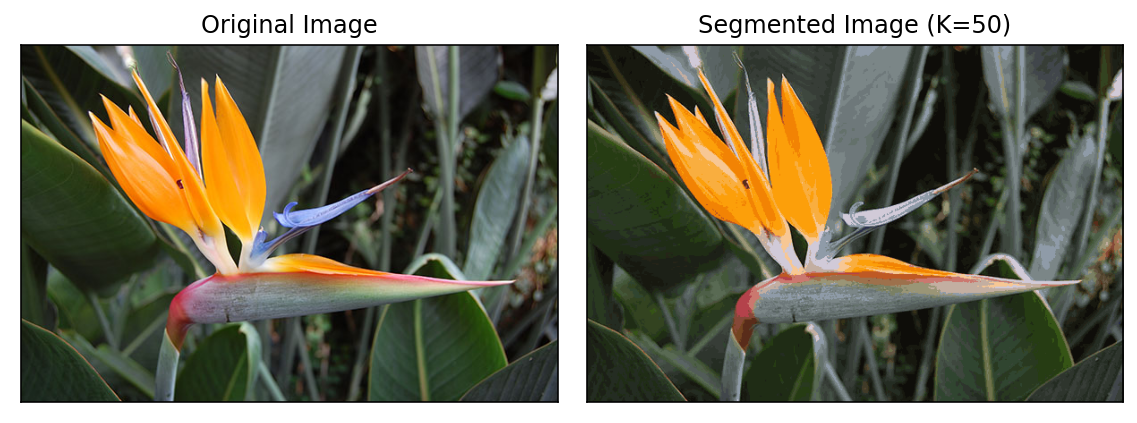

In [51]:
raw_image = io.imread("smallstrelitzia.jpg")
segment(raw_image, 10)
segment(raw_image, 20)
segment(raw_image, 50)

## 3.3 The Fish Image

.......... 

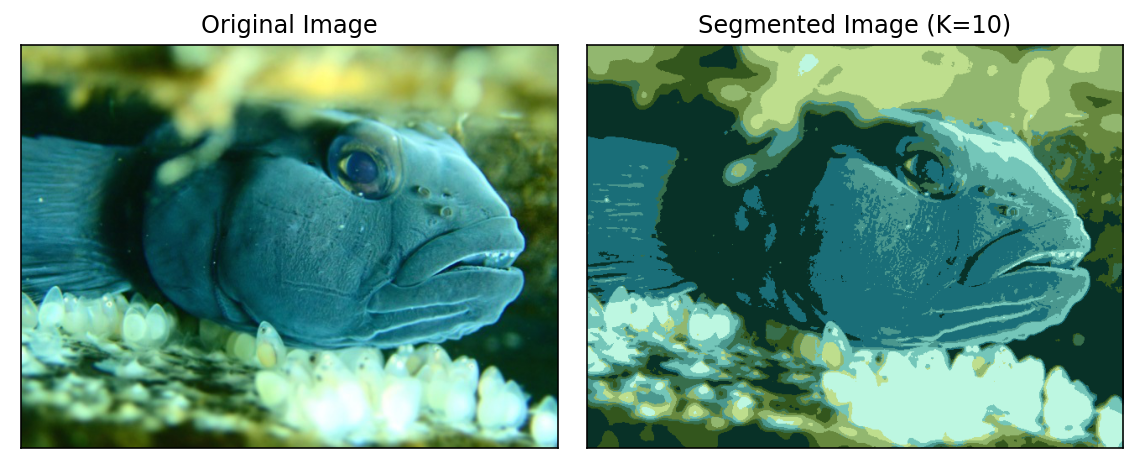

.......... 

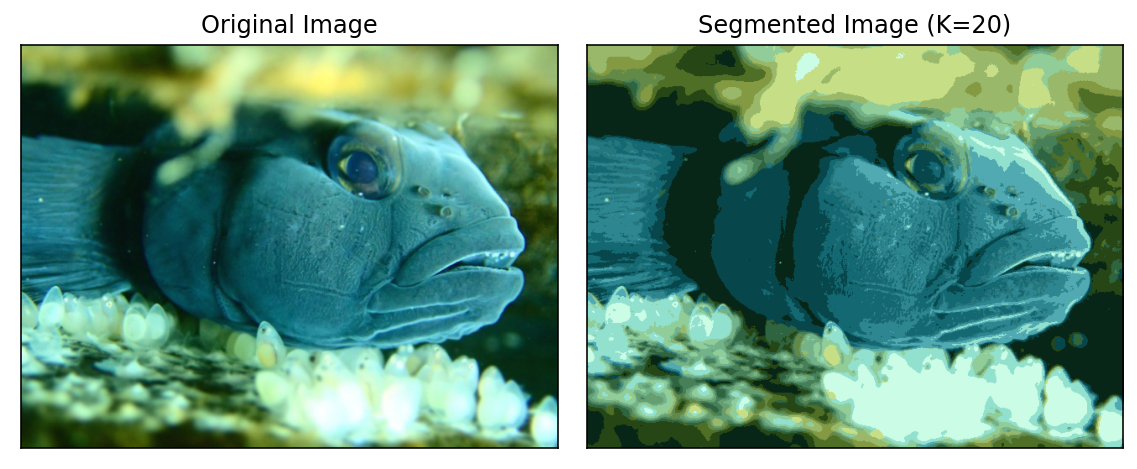

.......... 

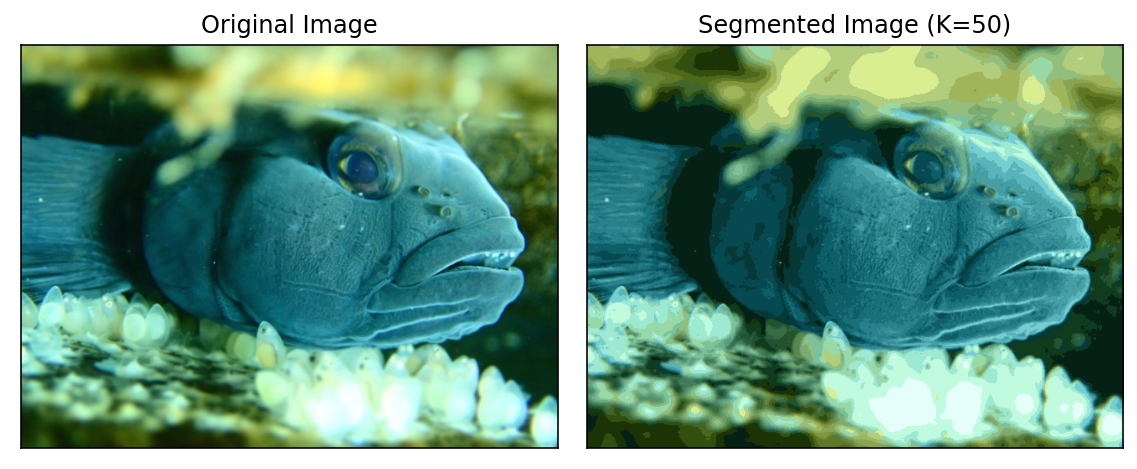

In [52]:
raw_image = io.imread("RobertMixed03.jpg")
segment(raw_image, 10)
segment(raw_image, 20)
segment(raw_image, 50)

.......... 

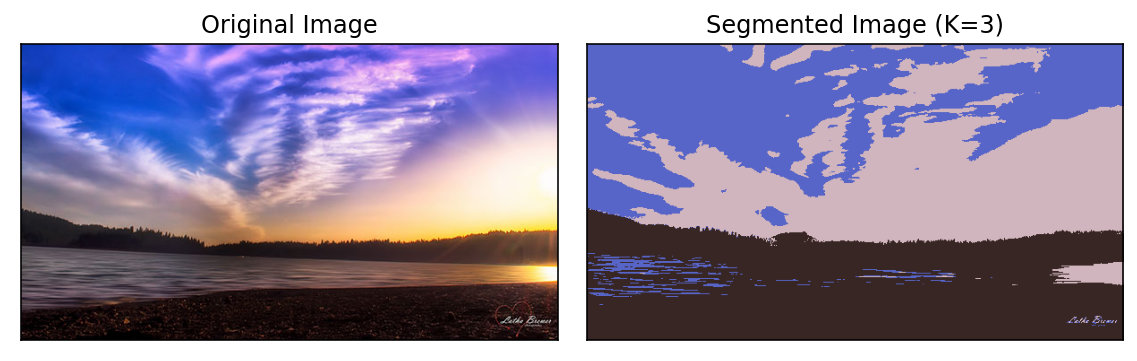

.......... 

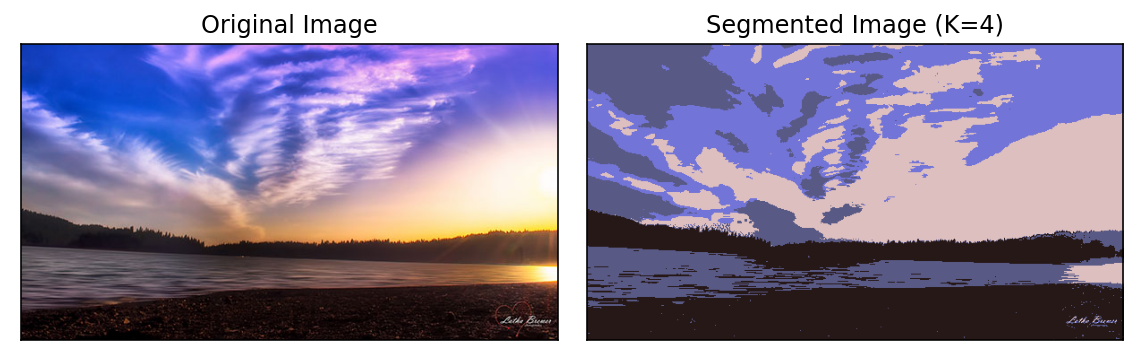

.......... 

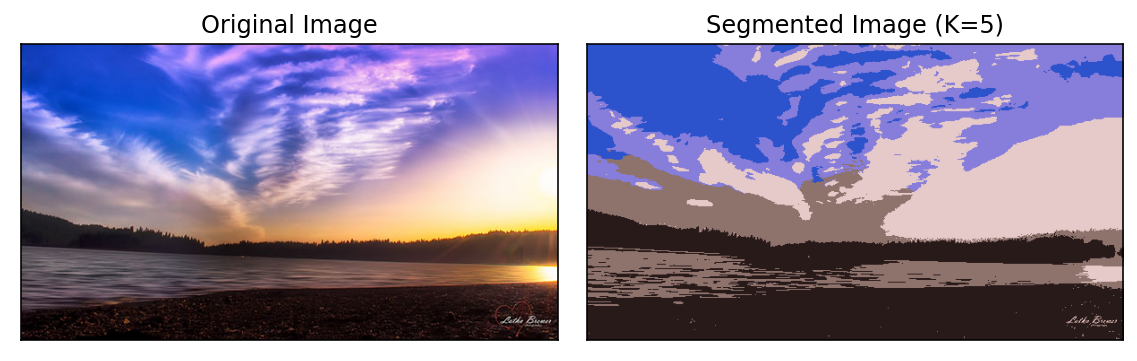

In [53]:
raw_image = io.imread("smallsunset.jpg")
segment(raw_image, 3)
segment(raw_image, 4)
segment(raw_image, 5)

.......... 

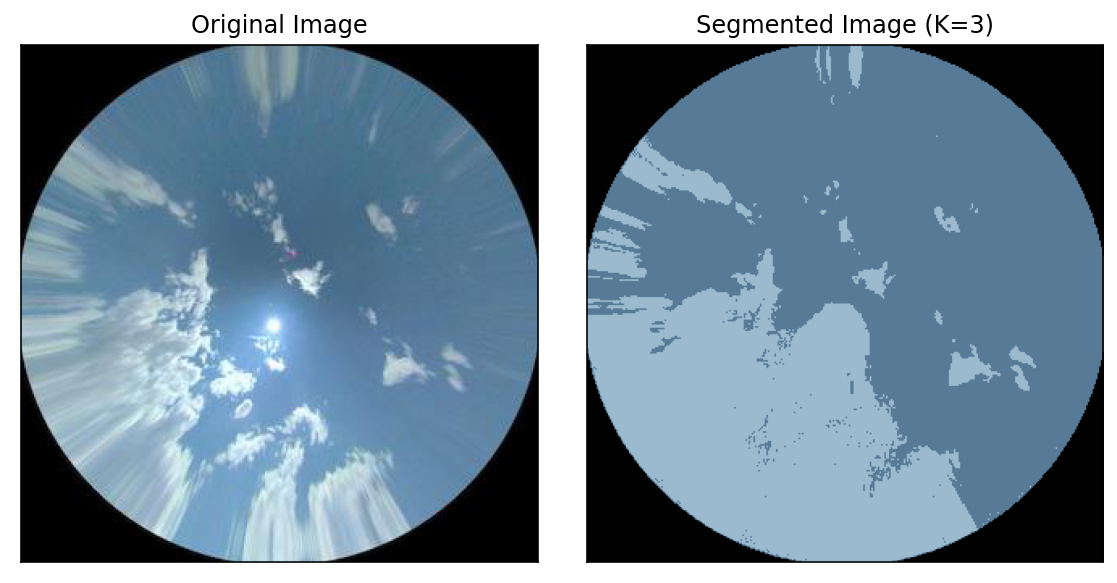

.......... 

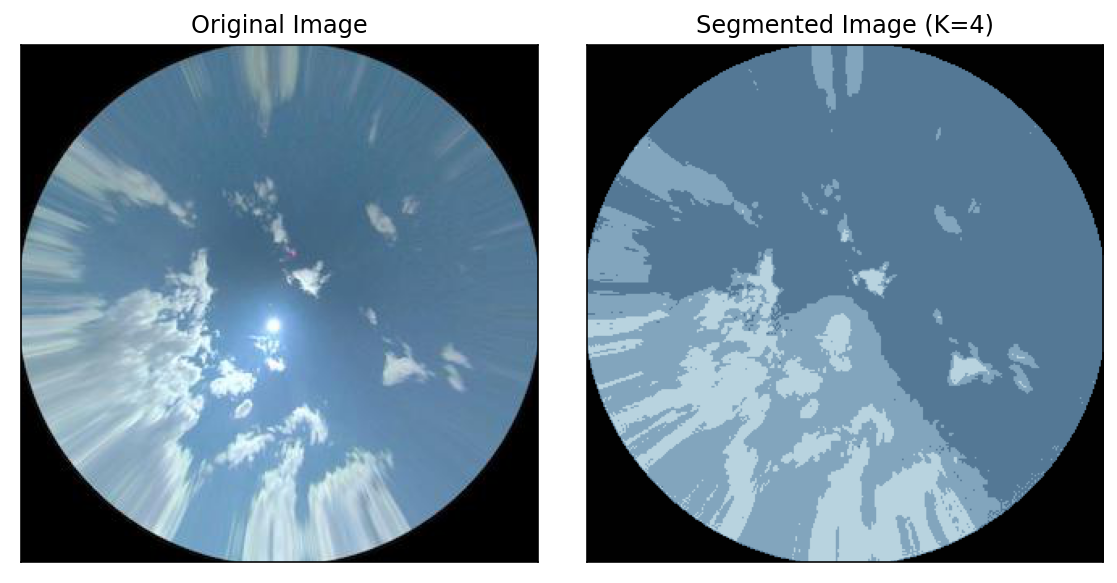

.......... 

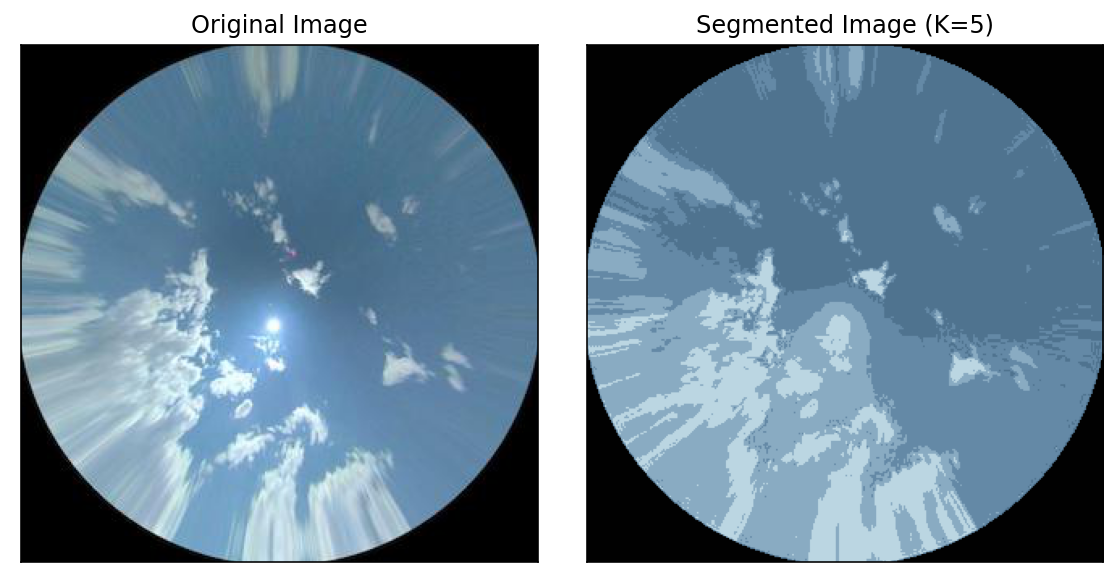

In [57]:
raw_image = io.imread("sky_img.jpg")
segment(raw_image, 3)
segment(raw_image, 4)
segment(raw_image, 5)